# Introduction: Business Problem

In this project we will try to predict the monthly rental price for a condominium. Specifically, this report will be targeted to stakeholders interested in finding the best value in renting a condominium in Singapore.

We will use our data science powers to find optimum rental price and recommend stake holders the best values and similar units for the stakeholders.

# Imports and Settings

In [86]:
#!pip install missingno

In [148]:
import pandas as pd
import numpy as np
from IPython.display import display


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.base import BaseEstimator, TransformerMixin

import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

import missingno as msno
import re
from collections import defaultdict

import sys
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

from missingpy import MissForest
from sklearn.impute import SimpleImputer

import geocoder

import pickle

In [88]:
#pandas setting
pd.set_option('max_columns', None)

#global rng
rng = np.random.RandomState(1)

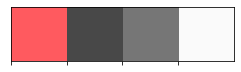

In [89]:
#colour template

pink = '#FF5A5F'
light_black = '#484848'
grey = '#767676'
background_color = "#fafafa"
face_color = '#fafafa'

sns.palplot([pink, light_black, grey, background_color])

# Data Description

|Feature|Type|Description|
|:---:|:---:|:---|
|**Amenities**|*Categorical*| Amenities of a Listing| 
|**bathroom**|*Discrete*|Number of bathroom of a listing|
|**bedroom**|*Discrete*|Number of bedroom of a listing|
|**detailed_address**|*Categorical*|address of a listing|
|**district**|*Categorical*|district number of a listing|
|**Floor Level**|*Nominal*|Low, Medium, High of a listing|
|**Furnishing**|*Nominal*|Furnished Level of a listing|
|**Link**|*Categorical*|website link to the listing|
|**mrt_distance**|*continuous*|walking time to the MRT|
|**mrt**|*continuous*|nearest MRT|
|**overview**|*Categorical*|Facing or View of the listing|
|**picture_url**|*Categorical*|picture of the listing|
|**picture_month**|*Continuous*|monthly price of the listing|
|**picture_sqrt**|*Continuous*|price_sqrt of the listing|
|**sqft**|*Continuous*|sqrt of the listing|
|**year_built**|*Discrete*|year built of the listing|

In [90]:
df = pd.read_csv("Data\main_df.csv", index_col = 'Unnamed: 0')

In [91]:
df.shape

(7454, 26)

In [92]:
df = df.drop_duplicates()
df.shape

(7449, 26)

In [93]:
df = df.rename(columns={'price/sqft': 'price_sqft', 'name': 'building_name'})
df.head(2)

,detailed_address,lat,long,bedrooms,bathrooms,sqft,price_sqft,developer,district,built_year,facing,floor_level,furnishing,amenities,mrt_distance,mrt_name,building_name,neighbourhood,overlooking_view,property_type,tenure,total_units,unit_types,link,picture_url,price_month
0,3 Wallich Street,1.276893,103.844458,1,1.0,646,$10.53 psf,Guocoland Limited,Chinatown / Tanjong Pagar (D2),2016.0,North South,High (64 total),Fully,"['Penthouse', 'Stove', 'Library', 'Walk in clo...",5 min (75 m) from,Tanjong Pagar MRT,Wallich Residence,None,Pool view,Condo Whole Unit,99 Years,181.0,"Studio, 1, 2, 3, 4, 5 BR",https://www.99.co/singapore/rent/property/wall...,https://pic.99.co/v3/GkrtLkrfYpXDLrZQVeHtp2?wi...,"$6,800/mo"
1,1 Claymore Drive,1.307183,103.829515,4,4.0,"1,970",$2.54 psf,NaN,Orchard / River Valley (D9),1970.0,NaN,High,Partial,"['Bathtub', 'Renovated', 'Aircon', 'Maid room'...",10 min (478 m) from,Orchard MRT,Orchard Towers,Orchard,NaN,Condo Whole Unit,Freehold,58.0,"1, 3, 4, 5, 7 BR",https://www.99.co/singapore/rent/property/orch...,https://pic.99.co/v3/C8G5McHGEiEzGnQ6Y53vm5?wi...,"$5,000/mo"


In [94]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7449 entries, 0 to 7453
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   detailed_address  7409 non-null   object 
 1   lat               7449 non-null   float64
 2   long              7449 non-null   float64
 3   bedrooms          7442 non-null   object 
 4   bathrooms         7108 non-null   float64
 5   sqft              7449 non-null   object 
 6   price_sqft        7400 non-null   object 
 7   developer         6455 non-null   object 
 8   district          7449 non-null   object 
 9   built_year        7328 non-null   float64
 10  facing            555 non-null    object 
 11  floor_level       1318 non-null   object 
 12  furnishing        2306 non-null   object 
 13  amenities         7449 non-null   object 
 14  mrt_distance      6464 non-null   object 
 15  mrt_name          6464 non-null   object 
 16  building_name     7449 non-null   object 


#  Irrelavent Feature & Data Type &  Missing Values

## Irrelavent Feature

In [95]:
#irrelevant Feature
drop = [
'price_sqft',#price_sqft feature can be derived from price/sqrt. We will delete this feature it is a redundant feature
'developer',# we assumed developer has no impact on the price of a listing, should our model show bias, we will revist this feature
'total_units',# we assumed total_units has no impact on the price of a listing,, should our model show bias, we will revist this feature
'property_type', #condominium only
'unit_types',# we assumed unit_types has no impact on the price of a listing,, should our model show bias, we will revist this feature
]
df = df.drop(labels=drop, axis=1 )

## Dropping Variable With High Missing Value & Row-Wise with less than 5% of total sample

<AxesSubplot:>

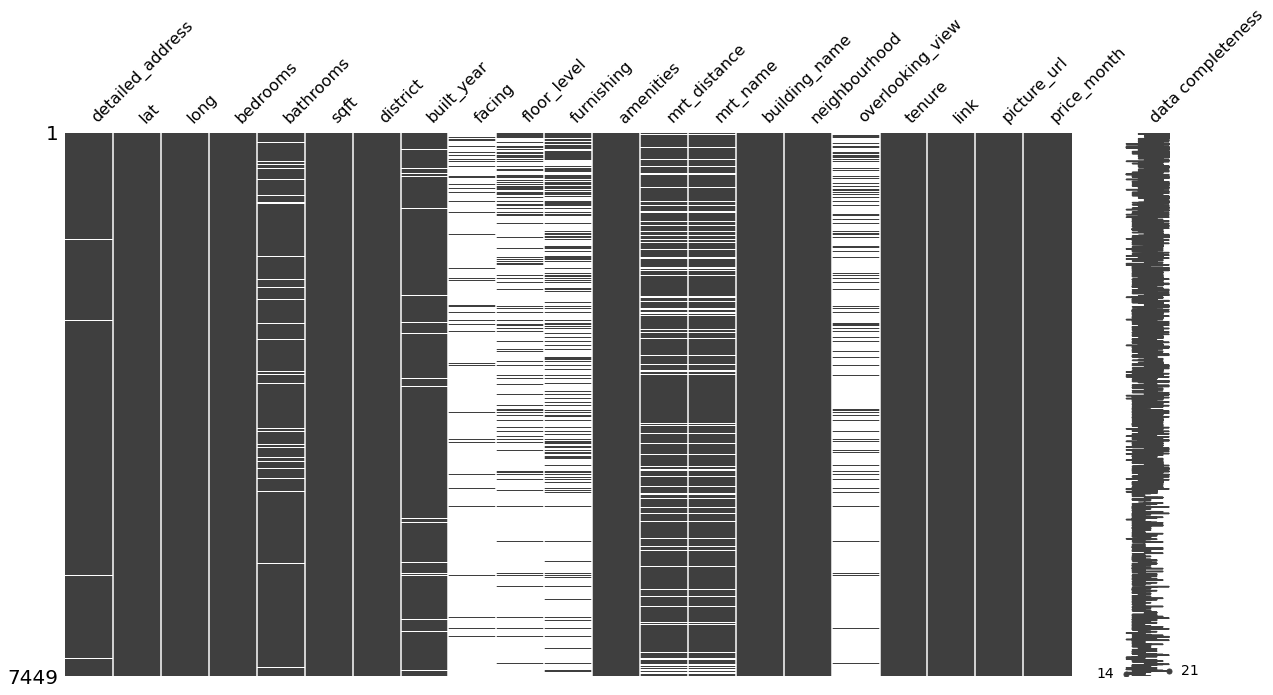

In [96]:
msno.matrix(df, labels=True, figsize=(20, 10))

<AxesSubplot:>

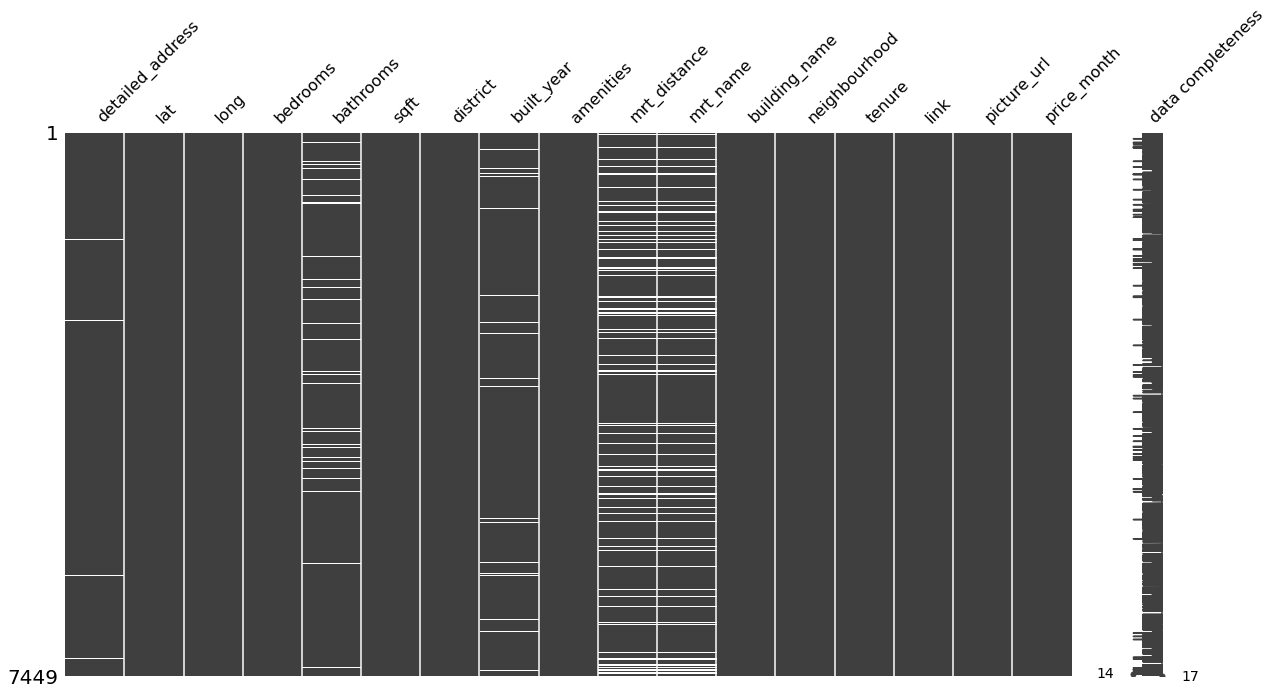

In [97]:
#dropping off column with more than 50% missing value (Reference multivariate-data-analysis-8th-edition rule of thumb)
thresh = len(df)*0.5
df = df.dropna(axis=1, thresh=thresh)
msno.matrix(df, labels=True, figsize=(20, 10))

In [98]:
df = df.dropna(axis=1, thresh=thresh)

In [99]:
## detailed_address is less than 1% we can drop it
df = df.dropna(axis=0, subset=['detailed_address'])

## Changing Data Type

### price_month

In [100]:
#changing price_month to numeric
df['price_month'] = pd.to_numeric(
    #placing the '/mo', '$', ','
    df.price_month.str.replace('/mo','').str.replace('$','').str.replace(',','')
)

<ipython-input-100-923808e2f9df>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df.price_month.str.replace('/mo','').str.replace('$','').str.replace(',','')


In [101]:
# there are some monthly price which are 0 and dont make sense. We will drop this rows as these are our target.
index = df[df.price_month == 0].index
df = df.drop(index)

### sqft

In [102]:
#price_sqrt
df['sqft'] = pd.to_numeric(
    df['sqft'].str.replace(',', "")
)

### mrt_distance

In [103]:
# mrt_distance
#There is two types of information. One is walking time the other one is distance. 
#We will create two feature from this raw input.

df['walking_time'] = df.mrt_distance.str.extract(r'([\d]+) min')
df['distance'] = df.mrt_distance.str.extract(r'([\d]+) m\)')

In [104]:
#converting object to numeric
df['walking_time'] =  pd.to_numeric(df.walking_time, errors='coerce')
df['distance'] = pd.to_numeric(df.distance, errors='coerce')

# we will drop mrt_walking distance since we have convert it into walking_time & distance column
df.drop('mrt_distance', axis = 1, inplace=True)

#### bedrooms

bedrooms contains object studio, we will create a new feature to indicate if the listing is a studio,  and replace bedrooms with 1

In [105]:
#new feature to indicate if studio
df['studio'] = np.where(df.bedrooms == 'studio', 1, 0)

#replace bedrooms for studio = 1
df['bedrooms'] = np.where(df.bedrooms == 'studio', 1, df.bedrooms)
df['bedrooms'] = pd.to_numeric(df.bedrooms)

### amenities

In [106]:
#cleaning amenities
#before
df['amenities'] = df.amenities.str.replace("'", "").str.replace('[', '').str.replace(']', '').str.replace(', ', ',')
df['amenities'][0]

<ipython-input-106-10fe62a2f114>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df['amenities'] = df.amenities.str.replace("'", "").str.replace('[', '').str.replace(']', '').str.replace(', ', ',')


'Penthouse,Stove,Library,Walk in closet,Jacuzzi,Oven,Renovated,Closet,,,,,,,,,,,,,,,,,'

In [107]:
#after
def cleaning(items):
    return [item for item in items.split(',') if item != '']
df['amenities'] = df['amenities'].apply(cleaning)
df['amenities'][0]

['Penthouse',
 'Stove',
 'Library',
 'Walk in closet',
 'Jacuzzi',
 'Oven',
 'Renovated',
 'Closet']

In [108]:
type(df['amenities'][0])

list

#### neighbhourhood

In [109]:
#replacing None with np.nan
df['neighbourhood'] = np.where(df.neighbourhood == 'None', np.nan, df.neighbourhood)

#### District

In [110]:
#changing data type of district
df['district_number'] = df.district.str.extract(r'D([\d]+)')

#converting object to numeric
df['district_number'] = pd.to_numeric(df.district_number, errors='coerce')

#we will drop district after covert it into numerical
df = df.drop('district', axis=1)

#### Tenure

In [111]:
#1 = Freehold, 0 = otherwise
df['tenure'] = np.where(df.tenure == 'Freehold', 1, 0)

In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7360 entries, 0 to 7453
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   detailed_address  7360 non-null   object 
 1   lat               7360 non-null   float64
 2   long              7360 non-null   float64
 3   bedrooms          7354 non-null   float64
 4   bathrooms         7024 non-null   float64
 5   sqft              7360 non-null   int64  
 6   built_year        7242 non-null   float64
 7   amenities         7360 non-null   object 
 8   mrt_name          6402 non-null   object 
 9   building_name     7360 non-null   object 
 10  neighbourhood     5530 non-null   object 
 11  tenure            7360 non-null   int32  
 12  link              7360 non-null   object 
 13  picture_url       7360 non-null   object 
 14  price_month       7360 non-null   int64  
 15  walking_time      6402 non-null   float64
 16  distance          6402 non-null   float64


## Imputation-1

### Row-wise not affected by datasnooping

#### Imputing mrt_name

i have searched a few listing on why they have not listed the mrt name, and it is due to it being far away from mrt.
i will impute it with No Mrt for mrt, and the distance/time will set to maximum of the value of the entire df

In [113]:
df.mrt_name.fillna('No_MRT', inplace=True)

In [114]:
df.walking_time.fillna(df.walking_time.max(), inplace=True)
df.distance.fillna(df.distance.max(), inplace=True)

#### Imputing Detailed Address

In [115]:
df.detailed_address.fillna('No_Address', inplace=True)

#### Imputing Neighbhourhood

There is 25% of missing value in *neighbhourhood*

In [116]:
df.neighbourhood.isna().sum()/len(df) * 100

24.86413043478261

In [117]:
# district number of missing value
missing_neighbhour = df.loc[df.neighbourhood.isna(), 'district_number'].value_counts()
missing_neighbhour

1    634
9    406
2    383
7    213
3    118
4     39
6     23
8     14
Name: district_number, dtype: int64

In [118]:
#entire district value count
df.district_number.value_counts().loc[missing_neighbhour.index]

1     634
9    1728
2     430
7     238
3     319
4     158
6      23
8     142
Name: district_number, dtype: int64

We can see that the **Neighbhour** missing value is not MCAR/MAR. In Fact the entire district 1 neighbhourhood is missing. Hence it could be that the neighbhour is not defined for a particular district.Instead of using neighbourhood. We will use district number instead.

In [119]:
df = df.drop('neighbourhood', axis=1)

# Anomaly/Outlier

Our main goal here is to remove outlier which is anomaly (value which is impossible). We will not remove outlier that is valid but extreme as compare to other value as this is not reality.

Note: However if one decided to remove valid outlier to suit a model, the outliers should be detected and removed only from the training set, and NOT from the test set. That way we can evaluate that our model is doing well despite removing the outlier.

In [120]:
def diagnostic_plots(df, variable, title):
    """
    function takes a dataframe and
    the variable of interest as arugments
    for checking outliers
    """
    
    fig , ax = plt.subplots(nrows = 1, ncols = 3, figsize=(15,4))
    
    #histogram
    sns.histplot(df[variable], bins='auto', ax=ax[0])
    ax[0].set_title('Distribution')
    
    #Q-Q plot
    stats.probplot(df.loc[~df[variable].isna(), variable], dist='norm', plot=ax[1])

    
    #boxplot
    sns.boxplot(y=df[variable], ax=ax[2])
    plt.title("Boxplot")
    
    fig.suptitle(title, fontsize=15)
    plt.show()

In [121]:
def find_skewed_boundary(df, variable, distance):
    
    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)
    
    lower_boundary = df[variable].quantile(0.25) - IQR * distance
    upper_boundary = df[variable].quantile(0.75) + IQR * distance
    print(f'{lower_boundary=}, {upper_boundary=}')
    return lower_boundary, upper_boundary

## Bathrooms

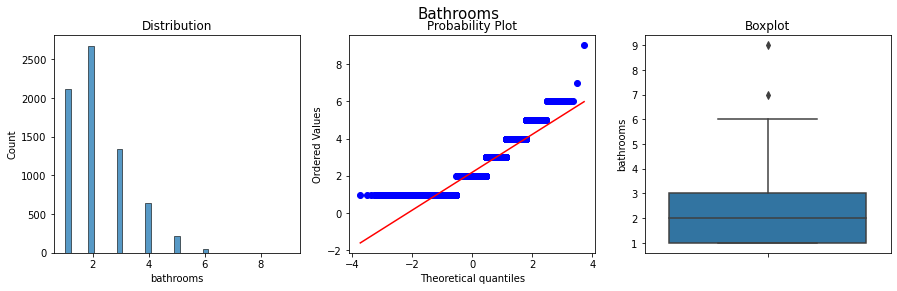

In [122]:
diagnostic_plots(df, 'bathrooms', title='Bathrooms')

In [123]:
#finding the outlier with 7 to 9 bathroom
df.loc[df.bathrooms.isin([7, 9]), :]

,detailed_address,lat,long,bedrooms,bathrooms,sqft,built_year,amenities,mrt_name,building_name,tenure,link,picture_url,price_month,walking_time,distance,studio,district_number
4522,18 Nassim Hill,1.306392,103.822328,5.0,7.0,7061,2015.0,"[Clubhouse, Gym, Sauna, Lounge, Swimming pool,...",No_MRT,The Nassim,1,https://www.99.co/singapore/rent/property/the-...,https://www.99.co/static/v3/icons/clubhouse@3x...,68000,35.0,5169.0,0,10
5659,3 Roberts Lane,1.310717,103.853502,10.0,9.0,8391,NaN,[],Farrer Park MRT,Zaman Centre,0,https://www.99.co/singapore/rent/property/zama...,https://financialtribune.com/sites/default/fil...,28000,5.0,250.0,0,8


Analysis above shows the the outlier is not an anomoly/entry error. It is indeed a high value valid listing. 
We will keep the "outlier"

## Bedrooms

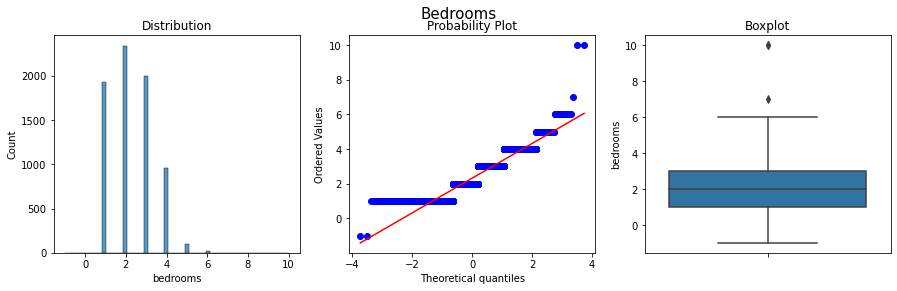

In [124]:
diagnostic_plots(df, 'bedrooms', title='Bedrooms')

In [125]:
#finding the outlier with more than 6 bedrooms
df.loc[df.bedrooms > 6, :]

,detailed_address,lat,long,bedrooms,bathrooms,sqft,built_year,amenities,mrt_name,building_name,tenure,link,picture_url,price_month,walking_time,distance,studio,district_number
2638,611 Geylang Road,1.313286,103.883081,10.0,2.0,2500,NaN,[],Aljunied MRT,Geylang Conservation Area,1,https://www.99.co/singapore/rent/property/geyl...,https://financialtribune.com/sites/default/fil...,8500,10.0,362.0,0,14
5659,3 Roberts Lane,1.310717,103.853502,10.0,9.0,8391,NaN,[],Farrer Park MRT,Zaman Centre,0,https://www.99.co/singapore/rent/property/zama...,https://financialtribune.com/sites/default/fil...,28000,5.0,250.0,0,8
6337,400 Orchard Road,1.298576,103.848676,7.0,NaN,2100,1970.0,[],Orchard MRT,Orchard Towers,1,https://www.99.co/singapore/rent/property/orch...,https://financialtribune.com/sites/default/fil...,7980,10.0,478.0,0,9


In [126]:
#finding the outlier with more than < 0 bedrooms
df.loc[df.bedrooms < 1, :]

,detailed_address,lat,long,bedrooms,bathrooms,sqft,built_year,amenities,mrt_name,building_name,tenure,link,picture_url,price_month,walking_time,distance,studio,district_number
239,503 Stirling Road,1.292097,103.804744,-1.0,1.0,100,NaN,"[Aircon, Bed, Low floor, Mid floor, High floor...",Queenstown MRT,MDIS Residences @ Stirling,0,https://www.99.co/singapore/rent/property/mdis...,https://www.99.co/static/v3/icons/aircon@3x.png,588,15.0,837.0,0,3
5219,2 Pandan Valley,1.318330,103.775830,-1.0,1.0,200,1978.0,"[Clubhouse, Gym, Swimming pool, Wading pool, S...",Dover MRT,Pandan Valley,1,https://www.99.co/singapore/rent/property/pand...,https://www.99.co/static/v3/icons/clubhouse@3x...,1600,30.0,4384.0,0,21


In [127]:
df = df.drop(index=[6337, 239, 5219])

We have analysis each of the above listing and found that #index 6337 is actually listing for office. We will proceed to delete it. Same for negative bedrooms as it does not make sense
#index 2638 is a valid listing. We will keep it

## Year Built

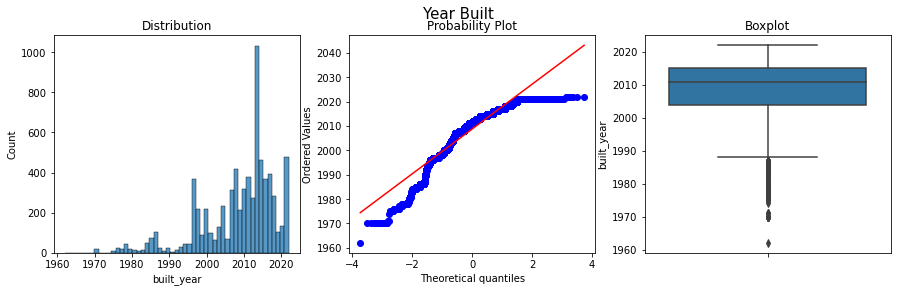

In [128]:
diagnostic_plots(df, 'built_year', title='Year Built')

we can see that most of the condominium listing in this dataframe are built around 2000 - 2015. The outlier of 1960 < date < 1990  is not an anomaly hence will be retained.

## Square Feet

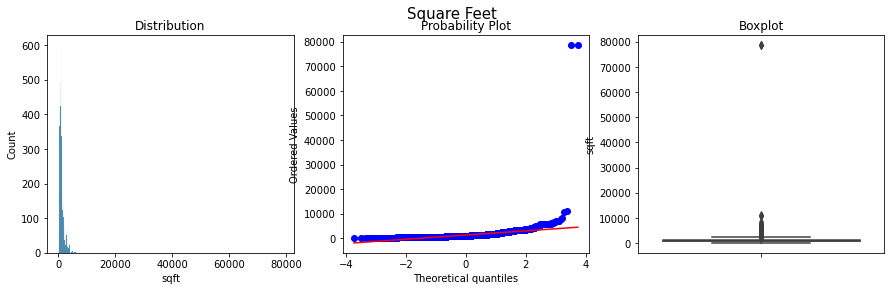

In [129]:
diagnostic_plots(df, 'sqft', title='Square Feet')

Lets remove the obvious Anomaly and re-plot

In [130]:
index = df.loc[df.sqft == df.sqft.max()].index

df = df.drop(index)

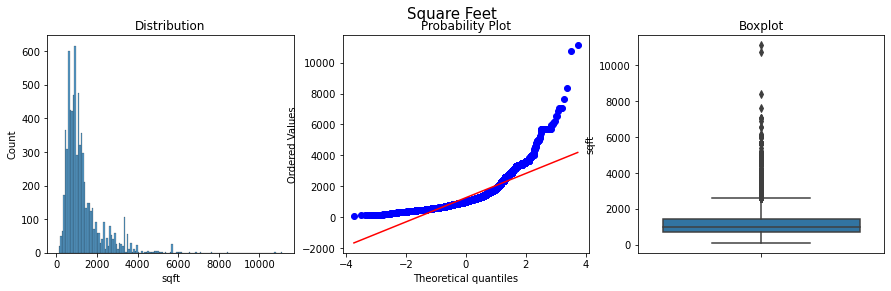

In [131]:
diagnostic_plots(df, 'sqft', title='Square Feet')

In [132]:
_ , upper = find_skewed_boundary(df, 'sqft', 3)


lower_boundary=-1603.0, upper_boundary=3745.0


In [133]:
df.loc[df.sqft > upper, ].shape[0]

129

There are aprox 130 extreme outliers. I have investigated the above listings and found that the sqft is valid and not a typo error. We should not delete these listings just because their values are extreme as they are part of the singapore condominium population

## Price_month

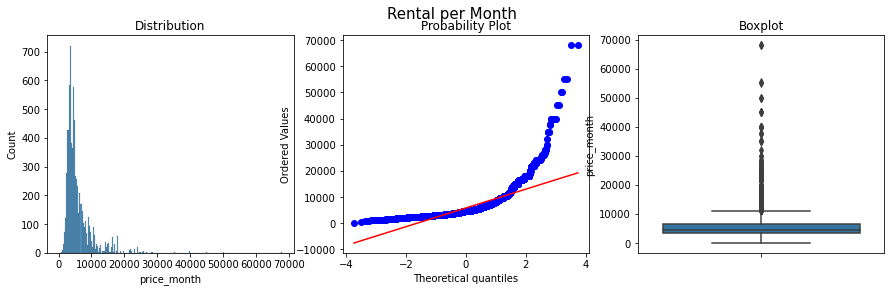

In [134]:
diagnostic_plots(df, 'price_month', title='Rental per Month')

We can see that the rental price per month is heavily skewed to the right and there are some price 0. We shall nvestigate these outliers

In [135]:
_, upper = find_skewed_boundary(df, 'price_month', 3)

lower_boundary=-5900.0, upper_boundary=15800.0


In [136]:
df.loc[df.price_month > upper, ].shape[0]

299

There are aprox 299 extreme outliers. I have investigated the above listings and found that the price_month is valid and not a typo error. We should not delete these listings just because their values are extreme as they are part of the singapore condominium population.

# Imputation 2

### Row-wise affected by datasnooping

In [137]:
# we want to preserve the ratio district hence stratifting df_strict
df_train, df_test = train_test_split(df, train_size=0.8,stratify=df[['district_number']],random_state=rng)

In [138]:
#General Function of Imputing Missing Value
#only works for imputing numerical value
def impute_missingvalue(df_train, df_test, used_column, missing_column):
    
    
    #create original dataframe to be combine with the column with missing value imputed
    df_train_original = df_train.copy()
    df_test_original = df_test.copy()
    
    #column used to impute value
    df_train = df_train.loc[:, used_column]
    df_test = df_test.loc[:, used_column]
    
    #select object column for columnstransformer for ohe
    object_column = df_train.select_dtypes('object').columns.tolist() 
    
    #create column transformer to transform object column, remainder will be passthrough
    ohe = OneHotEncoder(handle_unknown='ignore')
    ct = make_column_transformer(
        (ohe, object_column),
        remainder = 'passthrough'
    )     
    
#     #miss forest
    missforest = MissForest(random_state=rng)
    
#     #pipeline for transformation
    df_train = ct.fit_transform(df_train)
    train_columns = ct.get_feature_names()
    df_train = missforest.fit_transform(df_train.toarray())
    df_train = pd.DataFrame(df_train, columns = train_columns)
    
        
    df_test = ct.transform(df_test)
    df_test = missforest.transform(df_test.toarray())
    df_test = pd.DataFrame(df_test, columns = train_columns)
    
    for missing_feature in missing_column:
        df_train_original[missing_feature] = df_train[missing_feature].values
        df_test_original[missing_feature] = df_test[missing_feature].values


 
    return df_train_original, df_test_original
   

We will plot the before & after value distribution for columns with missing value to check if there is a change in distribution

In [139]:
def plot_missing_distribution(df_before,df_after, column, title):
    
    fig , ax = plt.subplots(nrows = 2, ncols = len(column), figsize=(16,6))

    for idx, col in enumerate(missing_value_columns):
        sns.histplot(df_before[col], bins='auto', ax=ax[0][idx],color='b')
        ax[0][idx].set_ylabel('')
        ax[0][idx].set_xlabel('')

        
    for idx, col in enumerate(missing_value_columns):
        sns.histplot(df_after[col], bins='auto', ax=ax[1][idx], color='r')
        ax[1][idx].set_ylabel('')
        

    fig.suptitle(title, fontsize=20);

    

In [140]:
#impute missing values
df_train_imp, df_test_imp = impute_missingvalue(df_train, 
                    df_test,
                    #features used to predict missing values                            
                    ['built_year', 'sqft', 'detailed_address','bedrooms', 'bathrooms', 'price_month', 'district_number'],
                    #features with missing values                             
                    ['built_year', 'bedrooms', 'bathrooms'] )

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2


Missforest returns the results as a continuous value.
we will need to round values for built_year, bedrooms, bathrooms as these are discrete values

In [141]:
missing_value_columns = ['built_year', 'bedrooms', 'bathrooms']

for col in missing_value_columns:
    df_train_imp[col] = np.round(df_train_imp[col])
    df_test_imp[col] = np.round(df_test_imp[col])

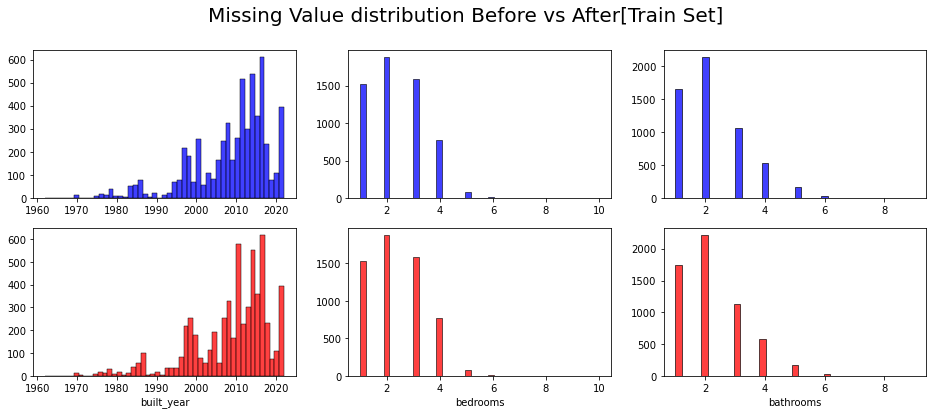

In [142]:
missing_value_columns = ['built_year', 'bedrooms', 'bathrooms']

plot_missing_distribution(df_train, df_train_imp, missing_value_columns, 'Missing Value distribution Before vs After[Train Set]')

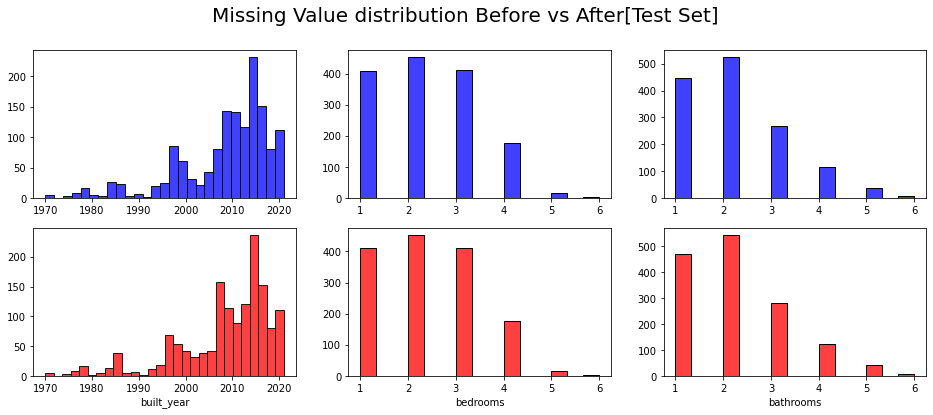

In [143]:
plot_missing_distribution(df_test, df_test_imp, missing_value_columns, 'Missing Value distribution Before vs After[Test Set]')

Before and After distribution does not change much. Our imputation method does not shift the distribution (shifting of distribution might lead to biasness)

<AxesSubplot:>

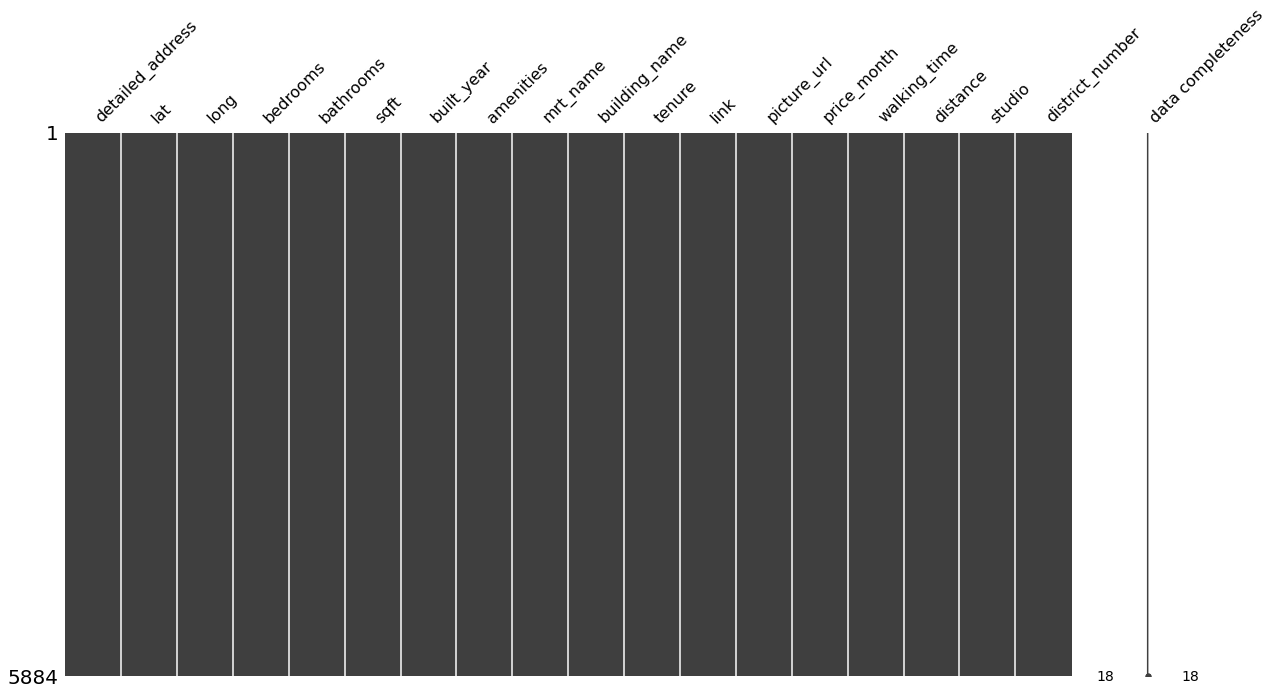

In [144]:
msno.matrix(df_train_imp, labels=True, figsize=(20, 10))

<AxesSubplot:>

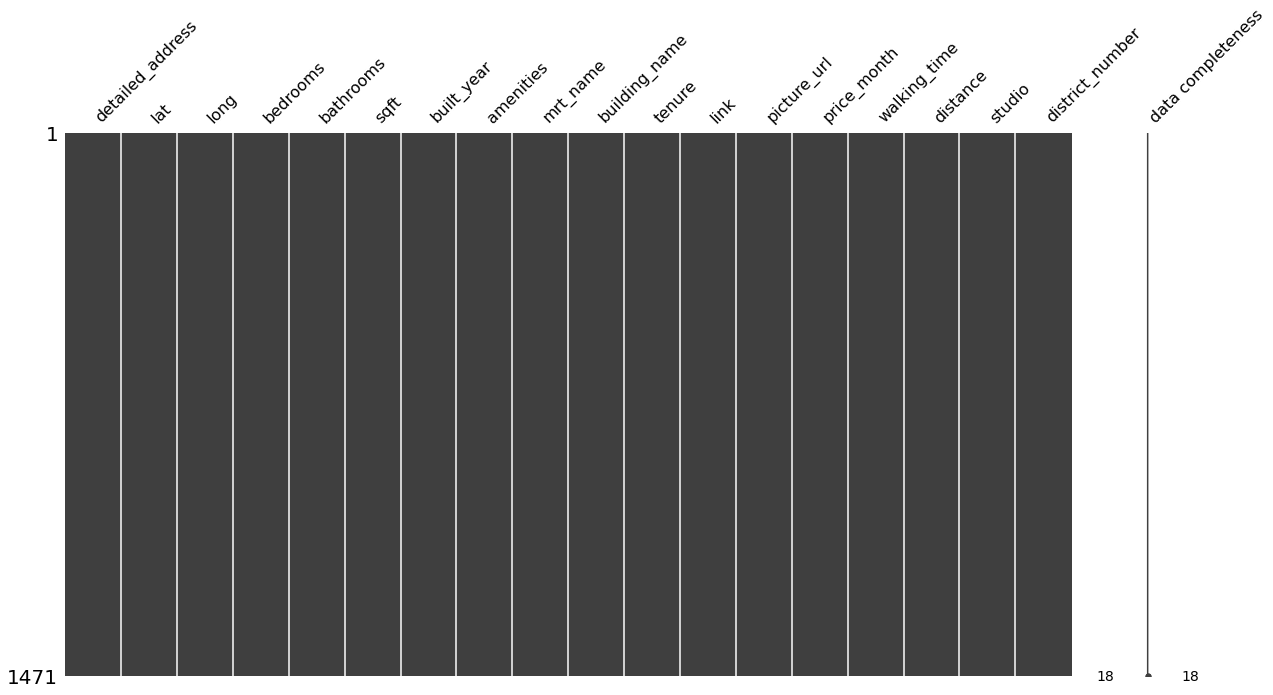

In [145]:
msno.matrix(df_test_imp, labels=True, figsize=(20, 10))

In [146]:
#override
df_train = df_train_imp
df_test = df_test_imp

In [150]:
# df_train.to_pickle('Data/df_train')
# df_test.to_pickle('Data/df_test')